# PCA Analysis
## BINF620 - Final Project

In [19]:
# Imports
import pandas as pd
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Seed
np.random.seed(1776)

In [20]:
# Analysis Vars
analysis_variables = [
    "SC_AGE_YEARS",    # Child's age in years
    "K8Q35",           # School engagement measure
    "ACE12",           # Adverse childhood experience - discrimination
    "PHYSACTIV",       # Physical activity level
    "age3_22",         # Age group categories
    "sex_22",          # Child's sex
    "MotherMH_22",     # Mother's mental health status
    "FatherMH_22",     # Father's mental health status
    "ScreenTime_22",   # Screen time categories
    "ACEct11_22",      # ACE count measure
    "ACE4ctCom_22",    # Community ACE measure
    "SC_RACE_R",       # Child's race/ethnicity
    "bully_22",        # Bullying others indicator
    "bullied_22",      # Being bullied indicator
    "AftSchAct_22",    # After-school activities participation
    "EventPart_22",    # Event participation
    "mentor_22",       # Mentorship availability
    "ShareIdeas_22",   # Sharing ideas with family
    "ACE6ctHH_22",     # Household ACE count
    "NbhdSupp_22",     # Neighborhood support
    "NbhdSafe_22",     # Neighborhood safety
    "FAMILY_R",        # Family structure
    "MHealthConcern"   # Our target variable (mental health concerns)
]

# Load Data
#result = pyreadr.read_r('/home/msmitty/Documents/BINF620/BINF620-R Projects/Final Project/binf620_FinalProject-Delivered/Data/currData_NSCH.RData')
result = pyreadr.read_r('/home/msmitty/Documents/BINF620/BINF620-R Projects/Final Project/binf620_FinalProject-Delivered/Data/imputed_NSCH.RData')
first_key = list(result.keys())[0]
df = result[first_key]

# Filter DF Age group 2/3
#df = df[df['age3_22'].isin([2, 3])]

print(df.head())


   SC_AGE_YEARS  HHCOUNT BORNUSA K8Q35 ACE12 PHYSACTIV  age3_22 sex_22  \
0            12        5       1     1     2         2        3      1   
1            12        4       2     2     2         4        3      1   
2             6        5       1     1     2         4        2      1   
3            11        5       1     2     2         4        2      1   
4            17        4       1     1     2         2        3      2   

  MotherMH_22 FatherMH_22  ... ShareIdeas_22 ACE6ctHH_22 NbhdSupp_22  \
0           1           2  ...             1           2           1   
1           1           1  ...             1           0           2   
2           2           2  ...             1           0           2   
3           2           1  ...             1           0           1   
4           3           2  ...             2           0           2   

  NbhdSafe_22 FAMILY_R K2Q32B K2Q33B K2Q32A K2Q33A MHealthConcern  
0           1        1     95     95      2      2    

In [21]:
# Pre Processing
def preprocess_for_pca(df):
    print("Starting comprehensive data preprocessing...")
    
    # Separate features and target
    X = df.drop('MHealthConcern', axis=1).copy()
    y = df['MHealthConcern'].copy()
    y = y.astype(str).astype(int)
    
    print(f"Original feature matrix shape: {X.shape}")
    print(f"Target variable distribution:")

    # Convert everything to float for PCA
    X = X.astype(float)
    
    print(f"\nPreprocessing complete!")
    
    return X, y, 0 #label_encoders

df = df[analysis_variables]
X, y, encoders = preprocess_for_pca(df)

Starting comprehensive data preprocessing...
Original feature matrix shape: (23572, 22)
Target variable distribution:

Preprocessing complete!


In [22]:
# Explore Mental health

# Calculate correlations between features and target
feature_target_corrs = []
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0,1]
    # Handle any potential NaN correlations
    if not np.isnan(corr):  
        feature_target_corrs.append((col, corr))

# Sort by absolute correlation strength
feature_target_corrs.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 10 variables correlated with mental health concerns:")
for i, (feature, corr) in enumerate(feature_target_corrs[:10], 1):
    direction = "Higher" if corr > 0 else "Lower"
    print(f"{i:2d}. {feature:15s}: {corr:6.3f} ({direction} values → more MH concerns)")


# Correlation Matrix
## feature_target_corrs


Top 10 variables correlated with mental health concerns:
 1. bullied_22     :  0.285 (Higher values → more MH concerns)
 2. ACEct11_22     :  0.275 (Higher values → more MH concerns)
 3. ACE4ctCom_22   :  0.247 (Higher values → more MH concerns)
 4. ACE6ctHH_22    :  0.223 (Higher values → more MH concerns)
 5. SC_AGE_YEARS   :  0.183 (Higher values → more MH concerns)
 6. ACE12          : -0.172 (Lower values → more MH concerns)
 7. bully_22       :  0.168 (Higher values → more MH concerns)
 8. ShareIdeas_22  :  0.162 (Higher values → more MH concerns)
 9. ScreenTime_22  :  0.157 (Higher values → more MH concerns)
10. age3_22        :  0.154 (Higher values → more MH concerns)


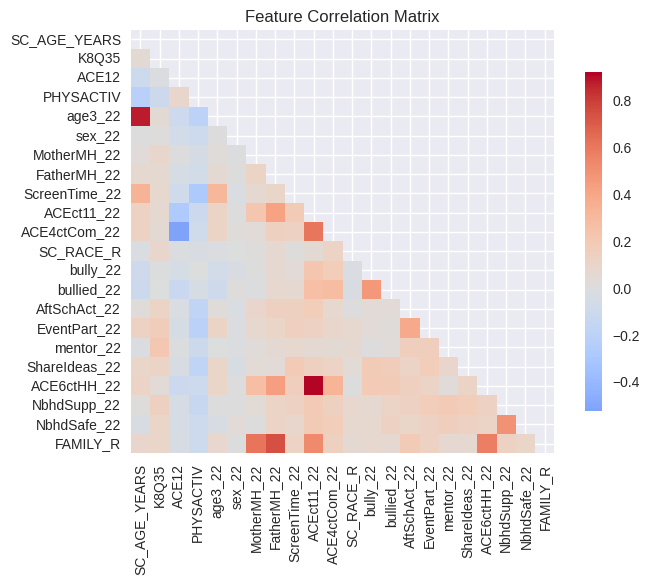

In [23]:
# Plot 1 | Correlation Matrix Heatmap
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.savefig('Results/pca/p1_featureCorrelationMatrix.png', dpi=300, bbox_inches='tight')

MHealthConcern
0    19022
1     4550
Name: count, dtype: int64


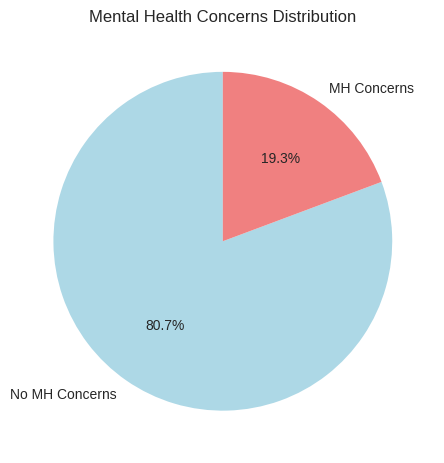

In [24]:
# Plot 2 | Distribution of target variable
target_counts = y.value_counts()
colors = ['lightblue', 'lightcoral']
plt.pie(target_counts.values, labels=['No MH Concerns', 'MH Concerns'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Mental Health Concerns Distribution')
plt.savefig('Results/pca/p2_MHealth_distributions.png', dpi=300, bbox_inches='tight')
print(target_counts)

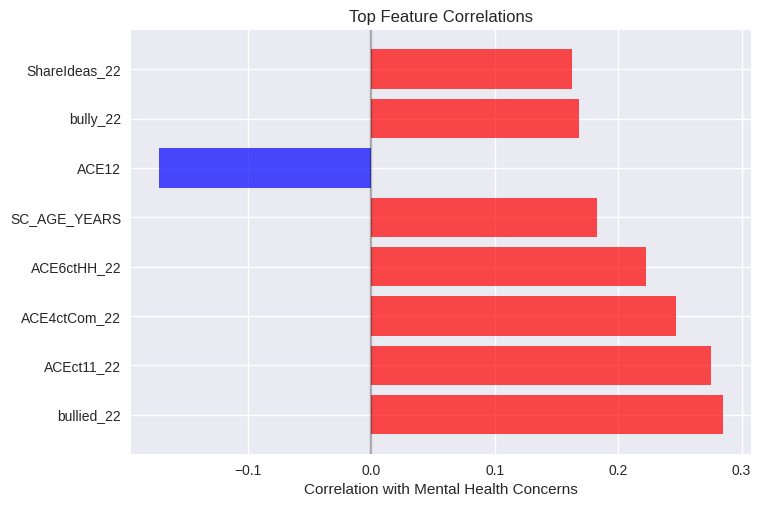

In [25]:
# Plot 3 | Top correlations bar plot
top_features = [item[0] for item in feature_target_corrs[:8]]
top_corrs = [item[1] for item in feature_target_corrs[:8]]
colors = ['red' if corr > 0 else 'blue' for corr in top_corrs]
bars = plt.barh(range(len(top_features)), top_corrs, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Correlation with Mental Health Concerns')
plt.title('Top Feature Correlations')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.savefig('Results/pca/p3_topCorrelations.png', dpi=300, bbox_inches='tight')

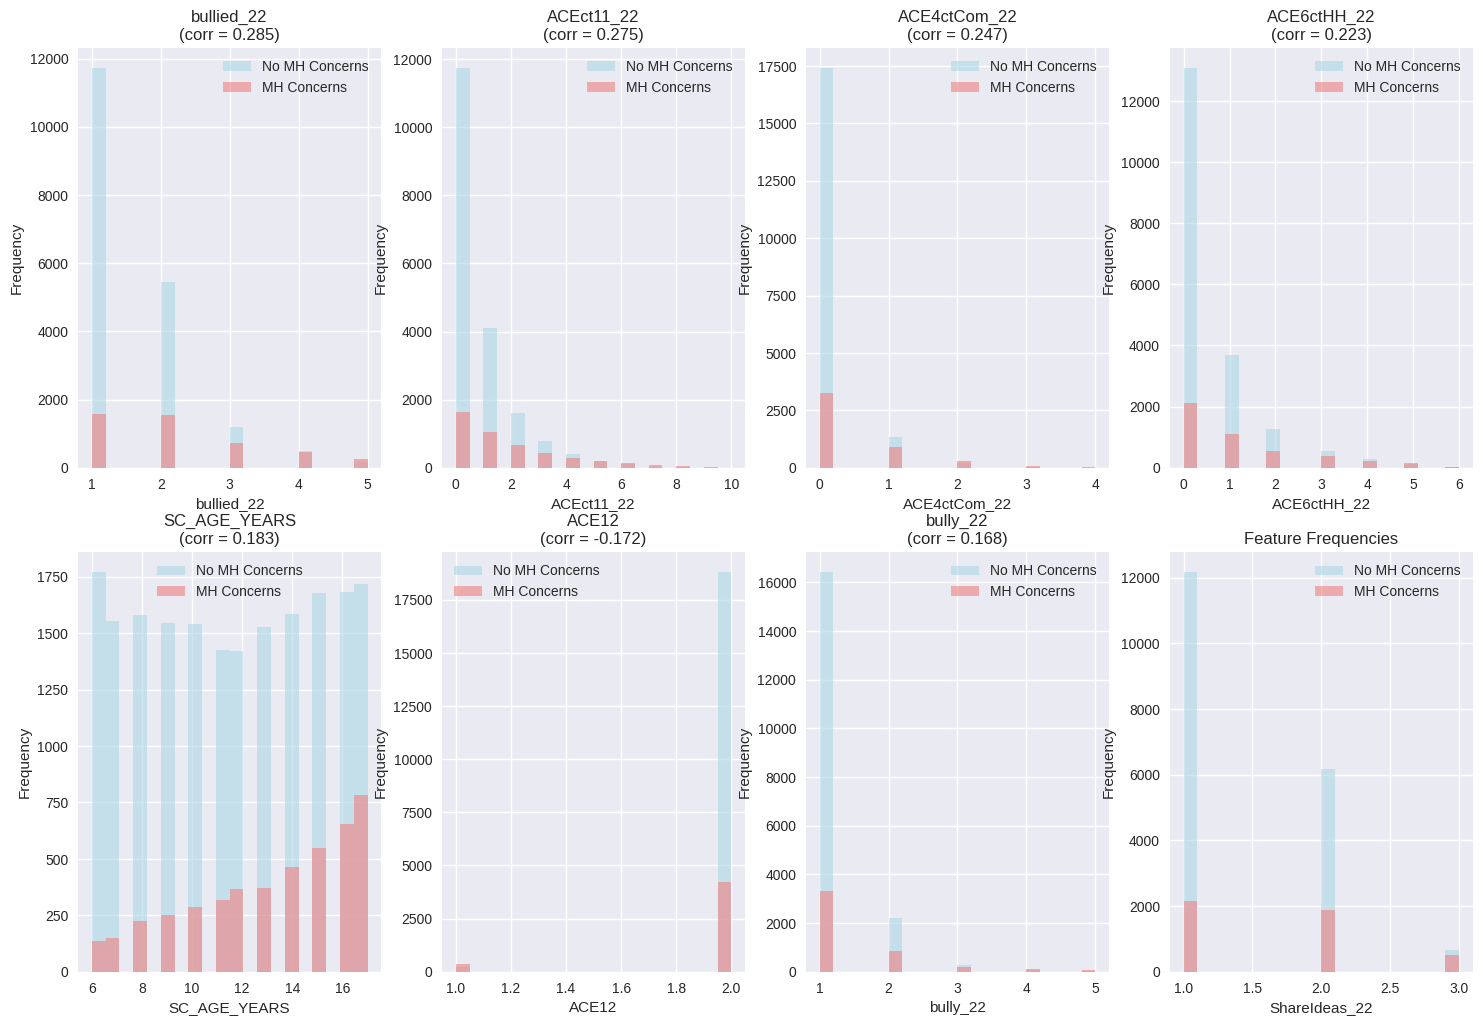

In [26]:
plt.figure(figsize=(18, 12))

# Plots 4 | Distribution plots for top 8 correlated features
for i, (feature, corr) in enumerate(feature_target_corrs[:8], 1):
    plt.subplot(2, 4, i)
    
    # Create separate distributions for each mental health group
    no_concern = X.loc[y == 0, feature]
    concern = X.loc[y == 1, feature]
    
    plt.hist(no_concern, alpha=0.6, label='No MH Concerns', bins=20, color='lightblue')
    plt.hist(concern, alpha=0.6, label='MH Concerns', bins=20, color='lightcoral')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature}\n(corr = {corr:.3f})')
    plt.legend()

plt.title('Feature Frequencies')
plt.savefig('Results/pca/p4_featureFrequency.png', dpi=300, bbox_inches='tight')

In [27]:
# Optimal Compoents
print("DETERMINING OPTIMAL NUMBER OF COMPONENTS")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform full PCA to analyze all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)
eigenvalues = pca_full.explained_variance_

# Apply selection criteria
# 1. Kaiser criterion: eigenvalues > 1
kaiser_components = np.sum(eigenvalues > 1)

# 2. 80% variance explained threshold
variance_80_components = np.argmax(cumulative_var >= 0.8) + 1

# 3. 90% variance explained threshold
variance_90_components = np.argmax(cumulative_var >= 0.9) + 1

# 4. Elbow method (look for sharp drops in eigenvalues)
eigenvalue_diffs = np.diff(eigenvalues)
elbow_component = np.argmax(eigenvalue_diffs) + 2  # Add 2 because diff reduces length by 1

# Choose optimal number (conservative approach: use 80% variance but limit to reasonable range)
optimal_components = max(min(variance_80_components, kaiser_components), 3)
optimal_components = min(optimal_components, 10)  # Cap at 10 for interpretability
    
# Final Values
#optimal_components, scaler, X_scaled

DETERMINING OPTIMAL NUMBER OF COMPONENTS


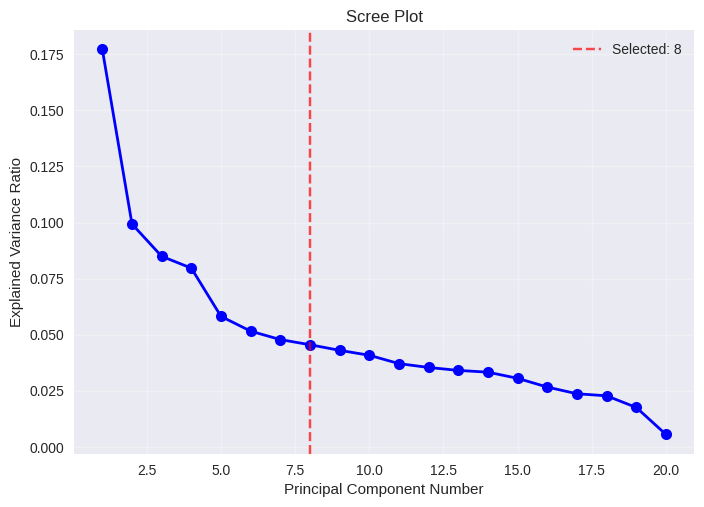

In [28]:
# Plot 5 | Scree plot
plt.plot(range(1, min(21, len(explained_var_ratio)+1)), 
            explained_var_ratio[:20], 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7, 
            label=f'Selected: {optimal_components}')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('Results/pca/p5_screeplot.png', dpi=300, bbox_inches='tight')

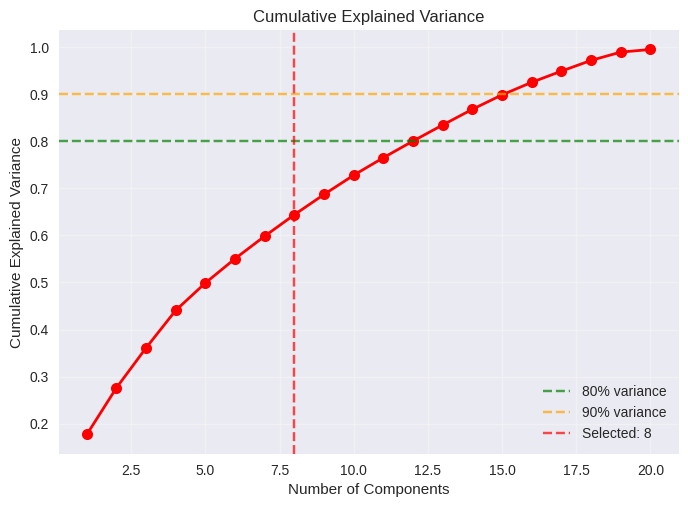

In [29]:
# Plot 6 | Cumulative explained variance
plt.plot(range(1, min(21, len(cumulative_var)+1)), 
            cumulative_var[:20], 'ro-', linewidth=2, markersize=8)
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% variance')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% variance')
plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7,
            label=f'Selected: {optimal_components}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('Results/pca/p6_ExplainedVariance.png', dpi=300, bbox_inches='tight')

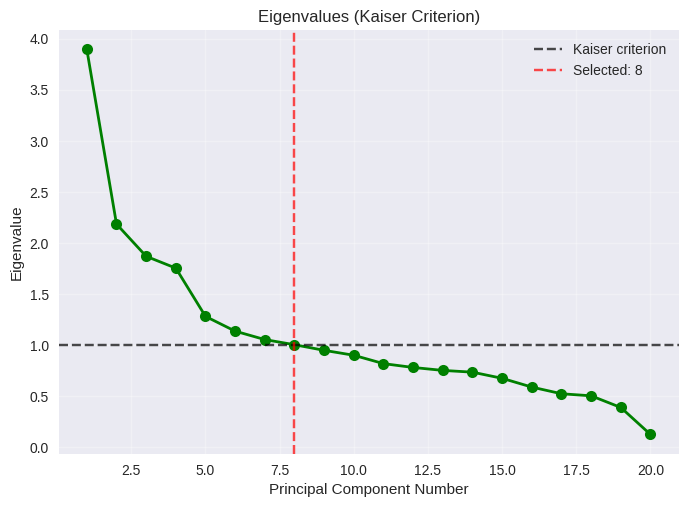

In [30]:
# Plot 7 | Eigenvalues
plt.plot(range(1, min(21, len(eigenvalues)+1)), 
            eigenvalues[:20], 'go-', linewidth=2, markersize=8)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Kaiser criterion')
plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7,
            label=f'Selected: {optimal_components}')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues (Kaiser Criterion)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('Results/pca/p7_eigenvalues.png', dpi=300, bbox_inches='tight')

In [31]:
# Perform_pca_transformation
feature_names = X.columns

print(f"PERFORMING PCA WITH {optimal_components} COMPONENTS")

# Fit PCA model
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA transformation complete!")
print(f"Original features: {X_scaled.shape[1]}")
print(f"Reduced to: {optimal_components} components")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Print individual component information
print(f"\nIndividual Component Information:")
for i in range(optimal_components):
    print(f"   PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} "
            f"({pca.explained_variance_ratio_[i]*100:.2f}% of variance)")

# Create loadings DataFrame
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(optimal_components)],
    index=feature_names
)
        
# Final Variables | X_pca, pca, loadings_df

PERFORMING PCA WITH 8 COMPONENTS
PCA transformation complete!
Original features: 22
Reduced to: 8 components
Total variance explained: 0.6442

Individual Component Information:
   PC1: 0.1771 (17.71% of variance)
   PC2: 0.0993 (9.93% of variance)
   PC3: 0.0849 (8.49% of variance)
   PC4: 0.0797 (7.97% of variance)
   PC5: 0.0582 (5.82% of variance)
   PC6: 0.0516 (5.16% of variance)
   PC7: 0.0478 (4.78% of variance)
   PC8: 0.0456 (4.56% of variance)



COMPONENT LOADINGS HEATMAP


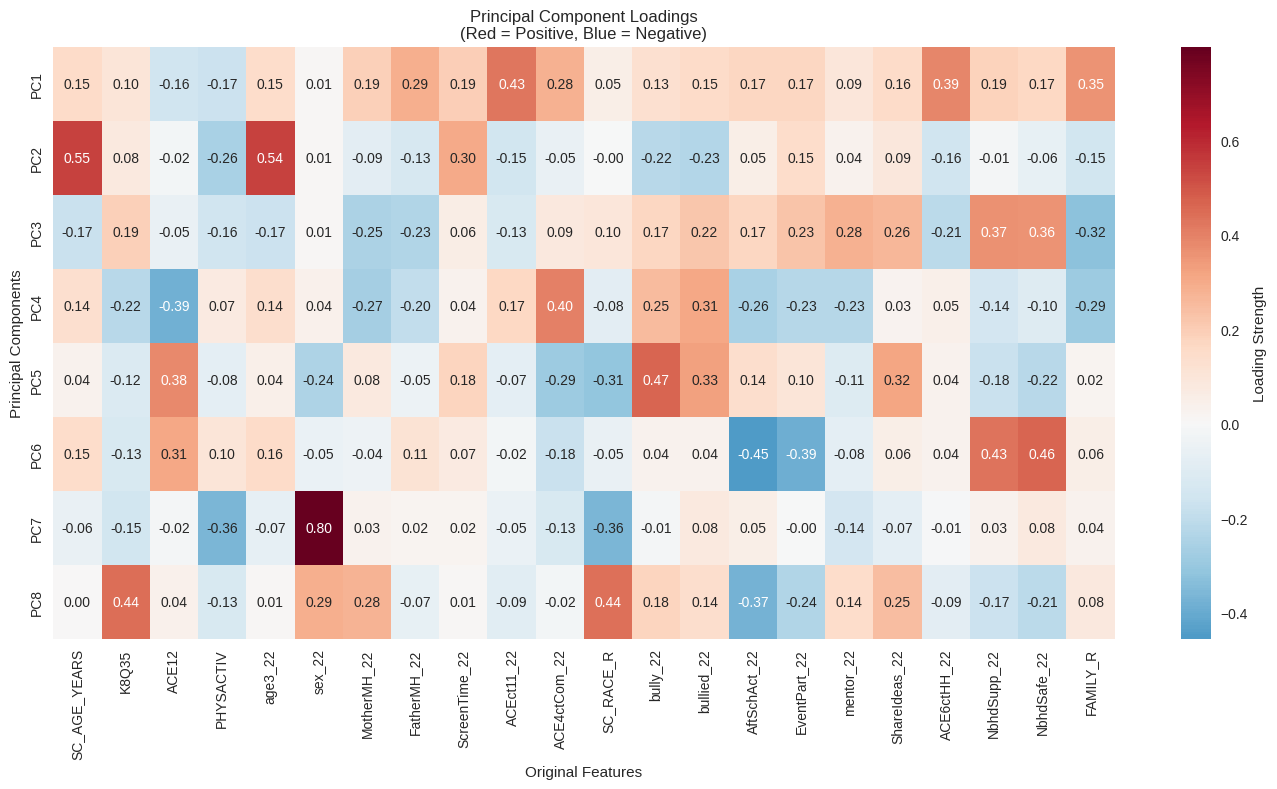

<Figure size 800x550 with 0 Axes>

In [32]:
# Plot 8 | Display the loadings matrix
print(f"\nCOMPONENT LOADINGS HEATMAP")
plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df.T, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', cbar_kws={'label': 'Loading Strength'})
plt.title('Principal Component Loadings\n(Red = Positive, Blue = Negative)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()
plt.savefig('Results/pca/p8_PCAHeatmap.png', dpi=300, bbox_inches='tight')

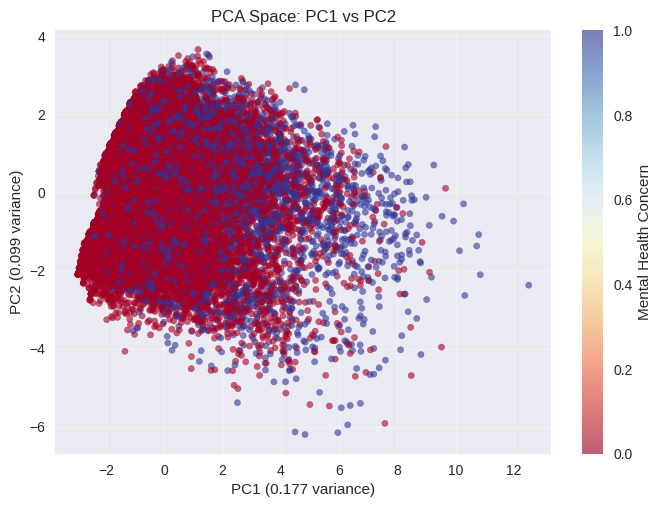

In [33]:
 # Plot 9 | 2D scatter plot of first two components
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA Space: PC1 vs PC2')
plt.colorbar(scatter, label='Mental Health Concern')
plt.grid(True, alpha=0.3)
plt.savefig('Results/pca/p9_pc1Vpc2.png', dpi=300, bbox_inches='tight')

In [34]:
print("BUILDING PREDICTIVE MODELS WITH PCA COMPONENTS")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

model_results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate performance metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate additional metrics from confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"{model_name} Results:")
    print(f"   AUC Score: {auc_score:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Sensitivity (Recall): {sensitivity:.4f}")
    print(f"   Specificity: {specificity:.4f}")
    print(f"   Precision: {precision:.4f}")
    
    # Store results
    model_results[model_name] = {
        'model': model,
        'auc_score': auc_score,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }
    
    # Print classification report
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['No MH Concern', 'MH Concern']))

# Final Variables | model_results, X_test, y_test

BUILDING PREDICTIVE MODELS WITH PCA COMPONENTS

Training Logistic Regression...
Logistic Regression Results:
   AUC Score: 0.7679
   Accuracy: 0.8276
   Sensitivity (Recall): 0.2117
   Specificity: 0.9749
   Precision: 0.6690

Detailed Classification Report for Logistic Regression:
               precision    recall  f1-score   support

No MH Concern       0.84      0.97      0.90      5707
   MH Concern       0.67      0.21      0.32      1365

     accuracy                           0.83      7072
    macro avg       0.75      0.59      0.61      7072
 weighted avg       0.81      0.83      0.79      7072


Training Random Forest...
Random Forest Results:
   AUC Score: 0.7660
   Accuracy: 0.8237
   Sensitivity (Recall): 0.1868
   Specificity: 0.9760
   Precision: 0.6505

Detailed Classification Report for Random Forest:
               precision    recall  f1-score   support

No MH Concern       0.83      0.98      0.90      5707
   MH Concern       0.65      0.19      0.29      1365


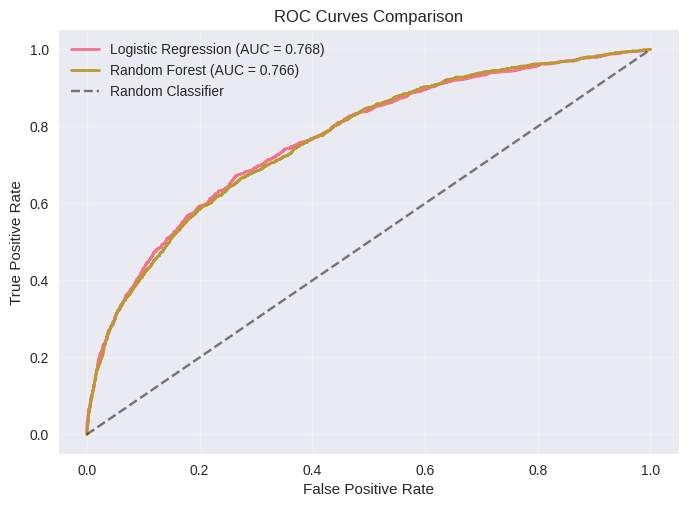

In [35]:
# Plot 10 | ROC Curves Comparison
for model_name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, 
            label=f"{model_name} (AUC = {results['auc_score']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Results/pca/p10_rocCurves.png', dpi=300, bbox_inches='tight')

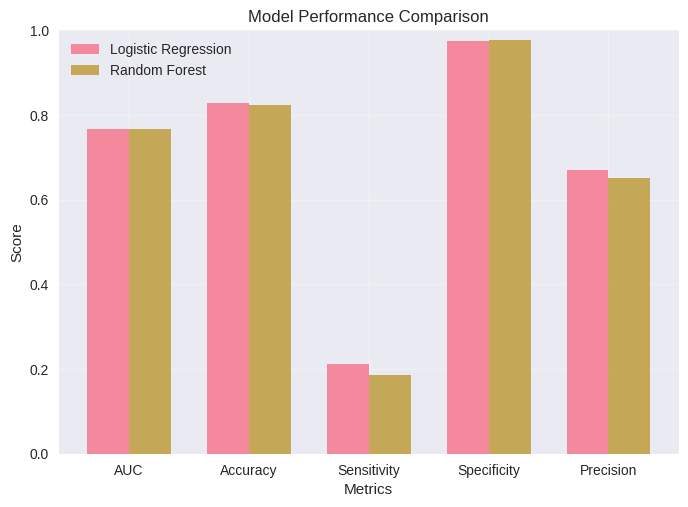

In [36]:
# Plot 11 | Model Performance Metrics Comparison

metrics = ['auc_score', 'accuracy', 'sensitivity', 'specificity', 'precision']
model_names = list(model_results.keys())

x = np.arange(len(metrics))
width = 0.35

for i, model_name in enumerate(model_names):
    values = [model_results[model_name][metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model_name, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width/2, ['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision'])
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.savefig('Results/pca/p11_modelPerformance.png', dpi=300, bbox_inches='tight')

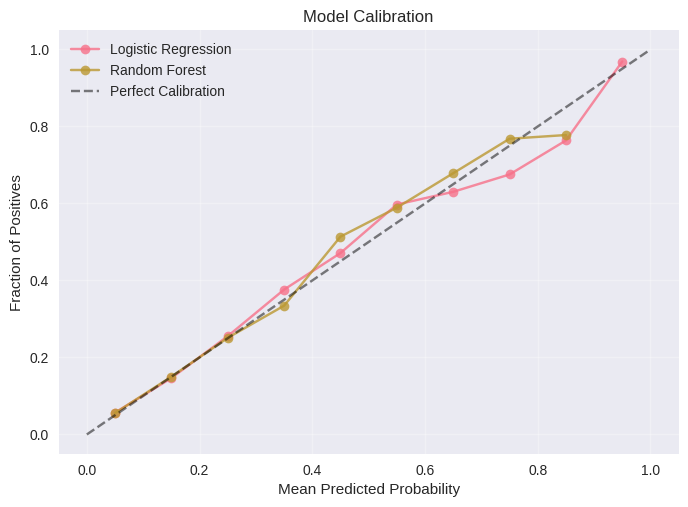

In [37]:
# Plot 12 | Model Calibration
for model_name, results in model_results.items():
    # Create calibration curve (simplified)
    prob_bins = np.linspace(0, 1, 11)
    bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
    
    true_rates = []
    for i in range(len(prob_bins)-1):
        mask = (results['y_pred_proba'] >= prob_bins[i]) & (results['y_pred_proba'] < prob_bins[i+1])
        if mask.sum() > 0:
            true_rate = y_test[mask].mean()
            true_rates.append(true_rate)
        else:
            true_rates.append(np.nan)
    
    plt.plot(bin_centers, true_rates, 'o-', label=model_name, alpha=0.8)



plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Model Calibration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Results/pca/p12_modelCalibration.png', dpi=300, bbox_inches='tight')

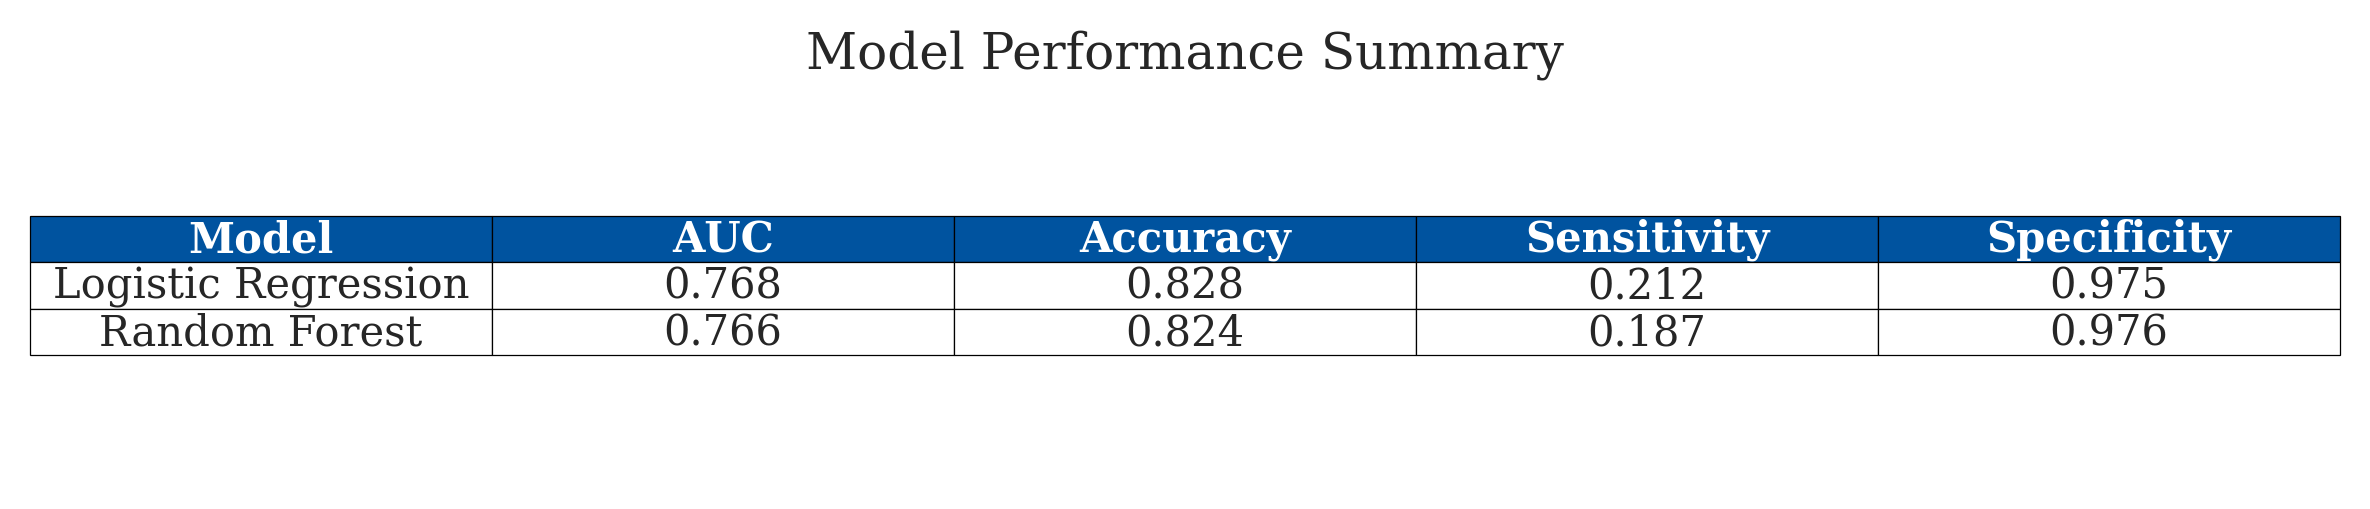

In [60]:
# Plot 13 | Summary Statistics Table
plt.figure(figsize=(8, 1.8))
plt.axis('off')

# Create summary table
summary_data = []
for model_name, results in model_results.items():
    summary_data.append([
        model_name,
        f"{results['auc_score']:.3f}",
        f"{results['accuracy']:.3f}",
        f"{results['sensitivity']:.3f}",
        f"{results['specificity']:.3f}"
    ])

col_labels = ['Model', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity']
table = plt.table(cellText=summary_data,
                    colLabels=col_labels,
                    cellLoc='center',
                    loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

# Header styling - use the actual number of columns
for i in range(len(col_labels)):
    table[(0, i)].set_facecolor('#00539f')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Model Performance Summary')
plt.tight_layout()

# Save BEFORE showing
plt.savefig('Results/pca/p13_ModelSummary.png', dpi=300, bbox_inches='tight')
plt.show()